In [1]:
import numpy as np
import numpy.linalg as la

import scipy as sp
import scipy.linalg as sla

import matplotlib.pyplot as plt

import tqdm 

import torch
import torch.nn as nn
import torch.functional as F

## Make some random non-negative X matrix

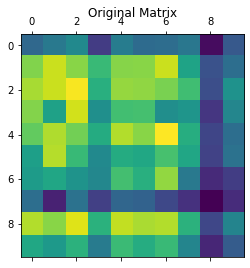

In [2]:
W = np.random.uniform(0, 1, size=(10,4))
H = np.random.uniform(0, 1, size=(4,10))
X = W @ H
plt.matshow(X)
plt.title('Original Matrix')
plt.show()

## Now define a neural network which is made up of a W^-1 and a W

NMF says $$X \approx WH$$

We're gonna make an autoencoder of the form 
$$\text{Encoder: }H = \sigma(W^{-1}X)$$ 
$$\text{Decoder: } \hat{X} = \sigma(W)H$$

The encoder will only output non-negative things, same with the decoder
$$\sigma(\cdot): \mathbb{R} \to \mathbb{R}_{\geq 0}$$


and will minimize $$\mathcal{L}(X, \hat{X}) = ||X - \hat{X}||^2_2$$

In [3]:
class NMF_Net(nn.Module):
    def __init__(self, X_height, k):
        super(NMF_Net, self).__init__()
        self.k = k
        self.W = nn.Parameter(torch.Tensor(X_height, k))
        self.W_inv = nn.Parameter(torch.Tensor(k, X_height))
        
        self.relu = nn.ReLU()
        
        # initialize W and W_inv
        nn.init.uniform_(self.W)
        nn.init.uniform_(self.W_inv)
        
    def forward(self, X):
        H = self.get_H(X) # this is the encoder
        
        X_hat = self.relu(self.W) @ H # this is the decoder
        return X_hat
    
    def get_H(self, X):
        return self.relu(self.W_inv @ X)
    
    def get_W(self):
        return self.W.data

In [4]:
net = NMF_Net(X.shape[0], 4)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2)
X_tensor = torch.FloatTensor(X)
n_trials = 200

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()
net.state_dict()

OrderedDict([('W', tensor([[0.5736, 0.3408, 0.0711, 0.3392],
                      [0.7303, 0.2822, 0.2555, 0.8547],
                      [0.8784, 0.6743, 0.1197, 0.4693],
                      [0.4888, 0.6367, 0.9762, 0.8166],
                      [0.7261, 0.2381, 0.7215, 0.1339],
                      [0.7806, 0.5156, 0.7612, 0.3570],
                      [0.3922, 0.3971, 0.9915, 0.4767],
                      [0.4566, 0.2807, 0.0383, 0.2574],
                      [0.0433, 0.9614, 0.3479, 0.9983],
                      [0.1216, 0.4084, 0.2233, 0.8525]])),
             ('W_inv',
              tensor([[0.6024, 0.6248, 0.2842, 0.7710, 0.4565, 0.5840, 0.7697, 0.8471, 0.5929,
                       0.1296],
                      [0.5119, 0.6694, 0.2846, 0.9960, 0.0296, 0.8906, 0.8575, 0.1536, 0.5919,
                       0.6926],
                      [0.7801, 0.0649, 0.4945, 0.6534, 0.5532, 0.6881, 0.1876, 0.7455, 0.4924,
                       0.5097],
                      [0.294

## Train it up

100%|██████████| 200/200 [00:00<00:00, 1361.47it/s]


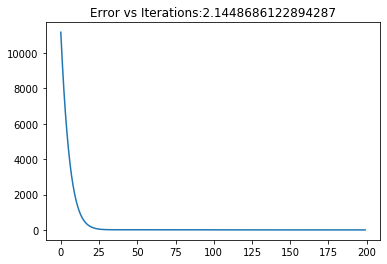

In [5]:
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net(X_tensor)
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

## Look at the factors it recovered

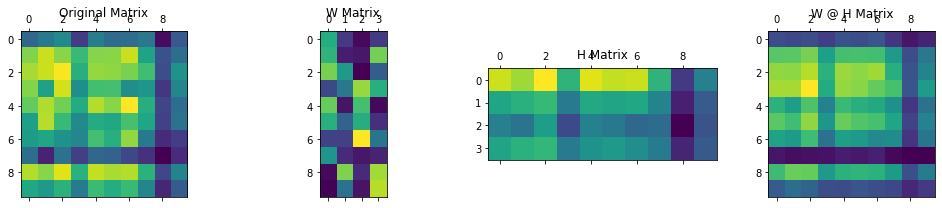

In [6]:
W_net = net.get_W().detach().numpy()
H_net = net.get_H(X_tensor).detach().numpy()

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].matshow(X)
ax[0].set_title('Original Matrix')

ax[1].matshow(W_net)
ax[1].set_title('W Matrix')

ax[2].matshow(H_net)
ax[2].set_title('H Matrix')

ax[3].matshow(W_net @ H_net)
ax[3].set_title('W @ H Matrix')

plt.tight_layout()
plt.show()

## Now, Recall SVD

SVD says that $$X =U \Sigma V^\top$$

Remember that:

$$U - \text{Orthogonal}$$
$$V - \text{Orthogonal}$$
$$\Sigma - \text{Diagonal}$$

Having a network be non-negative like for NMF is easy...having it be orthogonal is a bit harder. We're gonna use the fact that any nxn orthogonal matrix can be represented with n householder reflectors.

Instead of having this be an autoencoder we're gonna basically just be computing SVD like it was a neural network. This will lets us do some interesting things like use better losses or make the orthogonal matrices faster to compute with. My current implementation assumes that things are square but this should be easy to change.

In [7]:
class HouseHolderLayer(nn.Module):
    def __init__(self, n, num_hhrs):
        super(HouseHolderLayer, self).__init__()
        
        self.hhrs = nn.ParameterList([])
        for i in range(num_hhrs):
            self.hhrs.append(nn.Parameter(torch.Tensor(n)))

    def mult_by_hhr(self, x, h):
        hT = h.unsqueeze(0)
        h = h.unsqueeze(1)
        beta = 2 / (h**2).sum()

        return x - beta * (h @ (hT @ x)) 
    
    def forward(self, x):
        res = self.mult_by_hhr(x, self.hhrs[0])
        for i in range(1, len(self.hhrs)):
            res = self.mult_by_hhr(res, self.hhrs[i])
        return res
    
class SVDNet(nn.Module):
    def __init__(self, n, num_hhrs):
        super(SVDNet, self).__init__()
        self.sigma = nn.Parameter(torch.ones(n,1))
        
        self.U = HouseHolderLayer(n, num_hhrs)
        self.VT = HouseHolderLayer(n, num_hhrs)
        
        for p in self.U.parameters():
            torch.nn.init.normal_(p)
        for p in self.VT.parameters():
            torch.nn.init.normal_(p)
        
    def get_USVT(self, device):
        eye = torch.eye(self.sigma.shape[0]).to(device)
        U = self.U(eye).detach().cpu().numpy()
        
        S = np.diag(self.sigma.data.cpu().numpy()[:,0])

        VT = self.VT(eye).detach().cpu().numpy()
        return U, S, VT
    
    def forward(self, x):
        return self.U(self.sigma * self.VT(x))

In [8]:
net = SVDNet(X.shape[0], X.shape[0])
optimizer = torch.optim.Adam(net.parameters(), lr=2e-1)
X_tensor = torch.FloatTensor(X)
n_trials = 500

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

net.train()
net.state_dict()

OrderedDict([('sigma', tensor([[1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.],
                      [1.]])),
             ('U.hhrs.0',
              tensor([-0.5370,  0.3362, -0.1829,  0.2521,  0.6323, -0.1178, -1.4948, -0.3033,
                      -2.0712,  0.7926])),
             ('U.hhrs.1',
              tensor([-0.0976, -1.4195, -0.9443, -1.0276, -0.0778,  1.8123, -1.0602, -0.3032,
                       1.6812,  1.8492])),
             ('U.hhrs.2',
              tensor([-1.7411,  0.0147,  0.9475,  0.7153, -0.1043, -1.9008,  0.4650, -0.6866,
                       2.0241,  2.0705])),
             ('U.hhrs.3',
              tensor([ 0.1859,  0.4518, -1.4419, -0.4116, -0.6500,  0.6399,  1.1908, -1.0038,
                       0.9220, -0.4471])),
             ('U.hhrs.4',
              tensor([ 0.2107,

100%|██████████| 500/500 [00:03<00:00, 141.67it/s]


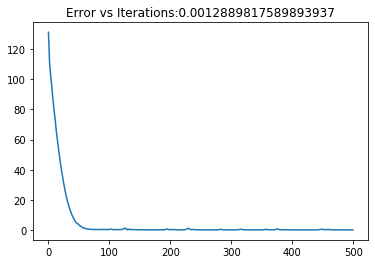

In [9]:
losses = np.zeros(n_trials)
for i in tqdm.tqdm(range(n_trials)):
    
    X_hat = net(torch.eye(X_tensor.shape[0]))
    cur_loss = loss(X_tensor, X_hat) 
    
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()
    
    losses[i] = cur_loss.item()

plt.plot(losses)
plt.title('Error vs Iterations:{}'.format(np.min(losses)))
plt.show()

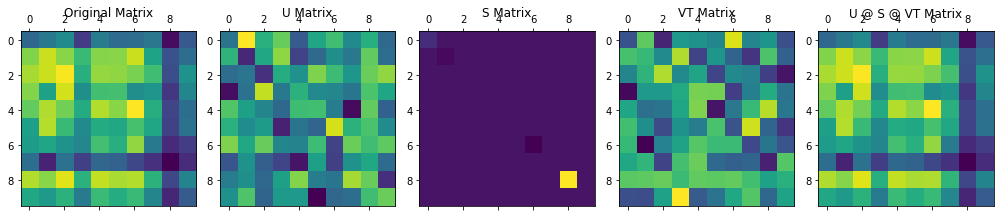

In [10]:
U, S, VT = net.get_USVT(X_tensor.device)

fig, ax = plt.subplots(1, 5, figsize=(14, 3))
ax[0].matshow(X)
ax[0].set_title('Original Matrix')

ax[1].matshow(U)
ax[1].set_title('U Matrix')

ax[2].matshow(S)
ax[2].set_title('S Matrix')

ax[3].matshow(VT)
ax[3].set_title('VT Matrix')

ax[4].matshow(U @ S @ VT)
ax[4].set_title('U @ S @ VT Matrix')

plt.tight_layout()
plt.show()